In [1]:
!pip install langchain_groq langchain langchain_community langgraph langsmith

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.7/409.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.21
    Uninstalling langchain-core-0.3.21:
      Successfully uninstalled langchain-core-0.3.21
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.9
    Uninstalling langchain-0.3.9:
      Successfully uninstalled langchain-0.3.9


In [3]:
from typing import Annotated
from typing_extensions import TypedDict
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.9 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=c9fb85597d1bfe5f461e485e539ae7bf7c0a3348c370760cee70e72237d90642
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=2861aaa760295638b3fac2efcdd185aff19140c09e68aa92c62b16d4977560e6
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built wikipedia sgmllib3k


##Working with Tools

In [5]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

##Calling Arxiv and Wikipedia tools

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper = arxiv_wrapper)

wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper = wiki)

In [8]:
tools = [wiki_tool]

##Langgraph Application

In [9]:
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list, add_messages]


In [10]:
from langgraph.graph import StateGraph, START,END

In [33]:
graph_builder2 = StateGraph(State)

In [12]:
from langchain_groq import ChatGroq

In [17]:
from google.colab import userdata
import os
GROQ_API_KEY = userdata.get('GROQ_API')
os.environ['GROQ_API_KEY'] = GROQ_API_KEY

In [18]:
llm = ChatGroq(model="gemma2-9b-it")

In [19]:
llm_with_tools = llm.bind_tools(tools=tools)

In [20]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [21]:
from langgraph.prebuilt import ToolNode, tools_condition

In [34]:
graph_builder2.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder2.add_node("tools", tool_node)

graph_builder2.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder2.add_edge("tools", "chatbot")
graph_builder2.add_edge(START,"chatbot")



In [35]:
graph = graph_builder2.compile()

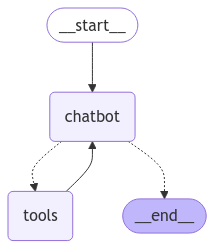

In [36]:
from IPython.display import Image,display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [39]:
user_input="Hi there!, My name is John"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is John
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_9hgd)
 Call ID: call_9hgd
  Args:
    query: John


/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================

It seems like there's not a lot of information about someone named John on Wikipedia.  Could you tell me more about John?  For example, what does he do?  Is he famous?
